<a href="https://colab.research.google.com/github/evildead23151/UIDAI-Hackathon-Analysis/blob/main/02_eda_univariate_bivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

BASE_IN = "/content/cleaned_outputs"

enrol_df = pd.read_csv(f"{BASE_IN}/clean_enrolment.csv")
demo_df = pd.read_csv(f"{BASE_IN}/clean_demographic_updates.csv")
bio_df = pd.read_csv(f"{BASE_IN}/clean_biometric_updates.csv")

enrol_df.shape, demo_df.shape, bio_df.shape


/tmp/ipython-input-1429519236.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  enrol_df = pd.read_csv(f"{BASE_IN}/clean_enrolment.csv")
/tmp/ipython-input-1429519236.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  bio_df = pd.read_csv(f"{BASE_IN}/clean_biometric_updates.csv")


((1006029, 7), (2071700, 6), (1861108, 6))

In [2]:
enrol_df.columns, demo_df.columns, bio_df.columns


(Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
        'age_18_greater'],
       dtype='object'),
 Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
        'demo_age_17_'],
       dtype='object'),
 Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object'))

In [4]:
def get_date_column(df):
    candidates = [c for c in df.columns if "date" in c.lower() or "time" in c.lower()]
    if len(candidates) == 0:
        raise ValueError("No date/time column found")
    col = candidates[0]
    if not np.issubdtype(df[col].dtype, np.datetime64):
        df[col] = pd.to_datetime(df[col], errors="coerce")
    return col


In [5]:
def temporal_span(df):
    date_col = get_date_column(df)
    return df[date_col].min(), df[date_col].max()

temporal_span(enrol_df), temporal_span(demo_df), temporal_span(bio_df)


((Timestamp('2025-01-04 00:00:00'), Timestamp('2025-12-11 00:00:00')),
 (Timestamp('2025-01-03 00:00:00'), Timestamp('2025-12-12 00:00:00')),
 (Timestamp('2025-01-03 00:00:00'), Timestamp('2025-12-12 00:00:00')))

# Monthly Aggregation (Core Time Series)

In [6]:
def monthly_aggregate(df, date_col, value_cols):
    return (
        df
        .set_index(date_col)
        .resample("M")[value_cols]
        .sum()
        .reset_index()
    )

enrol_monthly = monthly_aggregate(
    enrol_df,
    enrol_df.select_dtypes("datetime64[ns]").columns[0],
    enrol_df.select_dtypes("number").columns
)

demo_monthly = monthly_aggregate(
    demo_df,
    demo_df.select_dtypes("datetime64[ns]").columns[0],
    demo_df.select_dtypes("number").columns
)

bio_monthly = monthly_aggregate(
    bio_df,
    bio_df.select_dtypes("datetime64[ns]").columns[0],
    bio_df.select_dtypes("number").columns
)


/tmp/ipython-input-2962688656.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")[value_cols]
/tmp/ipython-input-2962688656.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")[value_cols]
/tmp/ipython-input-2962688656.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")[value_cols]


# Univariate Time Trends

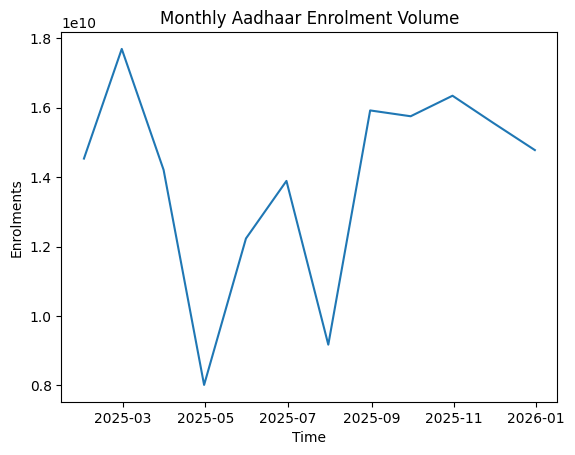

In [7]:
plt.figure()
plt.plot(enrol_monthly.iloc[:, 0], enrol_monthly.iloc[:, 1])
plt.title("Monthly Aadhaar Enrolment Volume")
plt.xlabel("Time")
plt.ylabel("Enrolments")
plt.show()


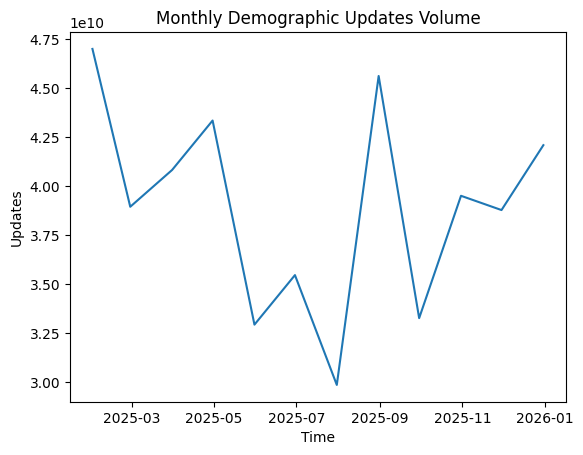

In [8]:
plt.figure()
plt.plot(demo_monthly.iloc[:, 0], demo_monthly.iloc[:, 1])
plt.title("Monthly Demographic Updates Volume")
plt.xlabel("Time")
plt.ylabel("Updates")
plt.show()


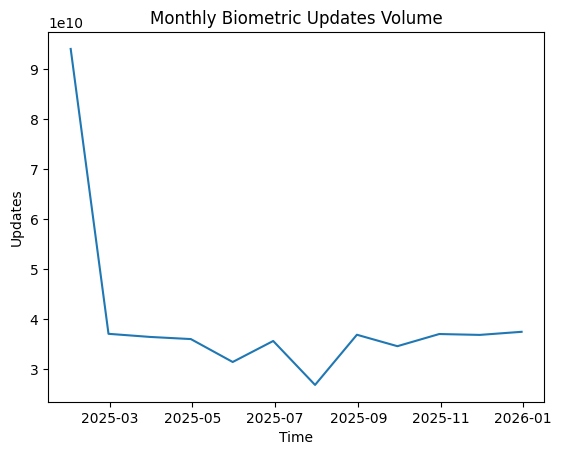

In [9]:
plt.figure()
plt.plot(bio_monthly.iloc[:, 0], bio_monthly.iloc[:, 1])
plt.title("Monthly Biometric Updates Volume")
plt.xlabel("Time")
plt.ylabel("Updates")
plt.show()


# Distribution Analysis (Heavy-Tailed Reality)

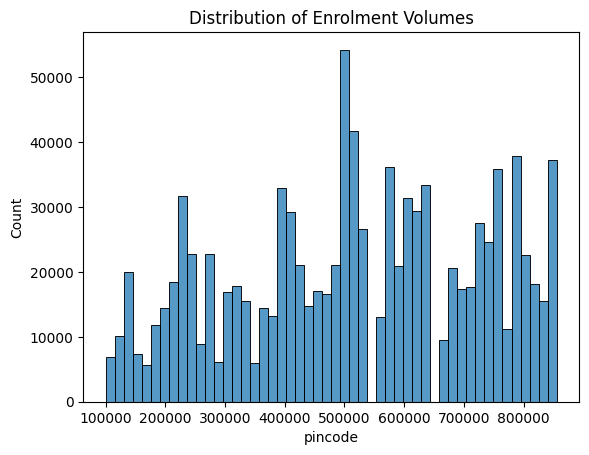

In [10]:
plt.figure()
sns.histplot(enrol_df.select_dtypes("number").iloc[:, 0], bins=50)
plt.title("Distribution of Enrolment Volumes")
plt.show()


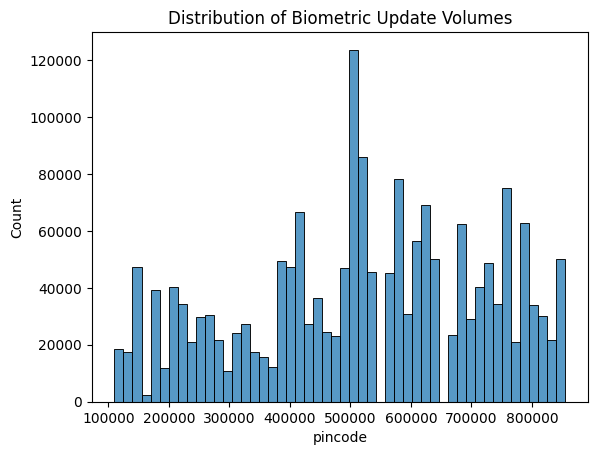

In [11]:
plt.figure()
sns.histplot(bio_df.select_dtypes("number").iloc[:, 0], bins=50)
plt.title("Distribution of Biometric Update Volumes")
plt.show()


# Geography Concentration (State-Level)

In [12]:
state_col = [c for c in enrol_df.columns if "state" in c.lower()][0]
value_col = enrol_df.select_dtypes("number").columns[0]

state_enrol = (
    enrol_df
    .groupby(state_col)[value_col]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

state_enrol


,pincode
state,
TAMIL NADU,57579986150
WEST BENGAL,55456789110
BIHAR,50417151103
KARNATAKA,40498813798
ANDHRA PRADESH,34212868727
ODISHA,33186774057
MAHARASHTRA,32457118198
KERALA,26693874763
UTTAR PRADESH,26357928404


# Bivariate Relationship: Enrolment vs Updates

In [13]:
merged_monthly = (
    enrol_monthly
    .merge(demo_monthly, on=enrol_monthly.columns[0], suffixes=("_enrol", "_demo"))
    .merge(bio_monthly, on=enrol_monthly.columns[0])
)

merged_monthly.head()


,date,pincode_enrol,age_0_5,age_5_17,age_18_greater,pincode_demo,demo_age_5_17,demo_age_17_,pincode,bio_age_5_17,bio_age_17_
0,2025-01-31,14535846739,713903,557337,95254,47012091784,1981758,17348747,94016981497,20827015,22937341
1,2025-02-28,17694516520,122401,52971,1304,38950750550,116968,977291,37014804244,666600,593410
2,2025-03-31,14210049809,68756,32638,2126,40829713113,129118,1117717,36386816521,563950,576240
3,2025-04-30,8016091692,43793,21728,835,43354782261,132013,1258533,35963289075,512443,526938
4,2025-05-31,12233839801,71641,28840,1181,32930119636,87902,749274,31377337066,389715,428201


# Ratio Analysis (High-Value Insight)

In [14]:
merged_monthly["demo_to_enrol_ratio"] = (
    merged_monthly.iloc[:, 2] / merged_monthly.iloc[:, 1]
)

merged_monthly["bio_to_enrol_ratio"] = (
    merged_monthly.iloc[:, 3] / merged_monthly.iloc[:, 1]
)

merged_monthly[["demo_to_enrol_ratio", "bio_to_enrol_ratio"]].describe()


,demo_to_enrol_ratio,bio_to_enrol_ratio
count,12.000000,12.000000
mean,0.000009,0.000005
std,0.000013,0.000010
min,0.000004,0.000002
25%,0.000005,0.000002
50%,0.000006,0.000003
75%,0.000006,0.000003
max,0.000049,0.000038


# Save EDA Outputs

In [15]:
merged_monthly.to_csv("/content/eda_monthly_merged.csv", index=False)
state_enrol.to_csv("/content/top_states_enrolment.csv")
